This notebook demonstrates how to use scATAcat, a tool designed for annotationg cell-types in scATAC-seq data. 

The necessary data to run the code provided below can be found [here](https://nc.molgen.mpg.de/cloud/index.php/s/9jrwRGzHgST2NK7). Please download the data and ensure it is stored in a folder named data.

In [1]:
import pickle
import pandas as pd
import sklearn
import numpy as np
import scanpy as sc
import scipy.sparse
import anndata
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import copy
import logging as logg
from sklearn import preprocessing
import os 
import warnings
import scATAcat
import seaborn as sns
import random as rn 

warnings.filterwarnings('ignore')

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


#### define necessary parameters

In [3]:
results_dir = "./results"
output_dir = results_dir + "/outputs/"
figures_dir = results_dir + "/figures/"
data_dir = "./data/"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### 0 - Load scATAC-seq data

Here we load the scATAC-seq data from [Buenrostro et al., 2018](https://www.sciencedirect.com/science/article/pii/S009286741830446X?via%3Dihub). This datset comprises of 2,210 cells human hematopoietic progenitor cells which are obtained from bone marrow and isolated via fluorescence-activated cell sorting (FACS). FACS enables sorting of single cells into a well plate using cell-type specific cell-surface markers and thereby provides a true cell-type annotation for each cell in the data. This means, we know the real cell-type identities of this cells.

Here, [ENCODE cCREs](https://www.nature.com/articles/s41586-020-2493-4) are used as the reference frame/features. We calculated the cCRE coverages for each cell, which is provided in `data/matrix_sparse.pkl`.
The column and index IDs of this matrix are given in `data/cell_IDs.csv` and `features.csv`, respectively.

In [4]:
ENCODE_coverage_per_cell_df= pickle.load(open(data_dir + 'matrix_sparse.pkl','rb'))


In [5]:
ENCODE_coverage_per_cell_df

<926535x2210 sparse matrix of type '<class 'numpy.float32'>'
	with 18562502 stored elements in Compressed Sparse Row format>

In [6]:
ENCODE_cCREs = pd.read_csv(data_dir +"features.csv", index_col=0)
ENCODE_cCREs.index.name = None
ENCODE_cCREs.columns = ['cCREs']
ENCODE_cCREs.head()

,cCREs
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060


In [7]:
cell_IDs = pd.read_csv(data_dir +"cell_IDs.csv", index_col=0)
cell_IDs.index.name = None
cell_IDs.columns = ['cell_IDs']
cell_IDs.head()

,cell_IDs
CLP_0,CLP_0
CLP_1,CLP_1
CMP_0,CMP_0
CMP_1,CMP_1
CMP_2,CMP_2


### 1 - initialize the AnnData object

scATAcat relies on [AnnData](https://anndata.readthedocs.io/en/latest/) package when working with datasets. Here we define an AnnData object from our scATAC-seq data.
Note that AmnnData requires observations as the columns and variables as indexes. We use [csr matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) format.

In [8]:
sc_completeFeatures_adata = anndata.AnnData(ENCODE_coverage_per_cell_df.transpose().tocsr(), var=ENCODE_cCREs, obs=cell_IDs)


In [9]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'

### 2 - add binary layer to AnnData

We binarize the matrix to enable further processing and filtering. This new matrix is added as a new layer to our AnnData object with the keyword "binary".

In [10]:
scATAcat.add_binary_layer(sc_completeFeatures_adata, binary_layer_key="binary")

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    layers: 'binary'

### 3- calculate & plot cell and feature statistics

`cell_feature_statistics()` function calculates the quality features like "number of features per cell" and "number of cells per feature". `plot_feature_statistics()` and `plot_cell_statistics()` functions enables viuzalizations of these quality features.

In [11]:
scATAcat.cell_feature_statistics(sc_completeFeatures_adata, binary_layer_key ='binary')

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

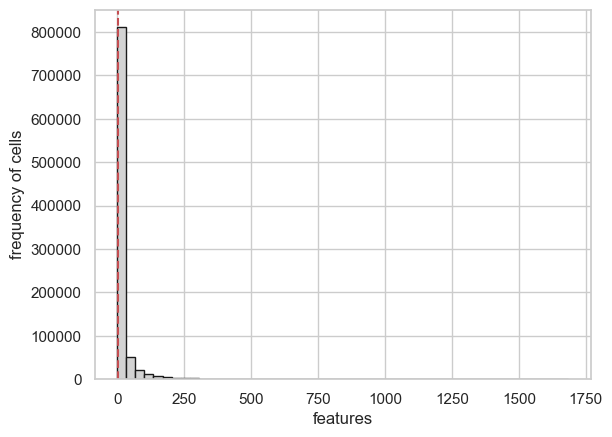

In [12]:
scATAcat.plot_feature_statistics(sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

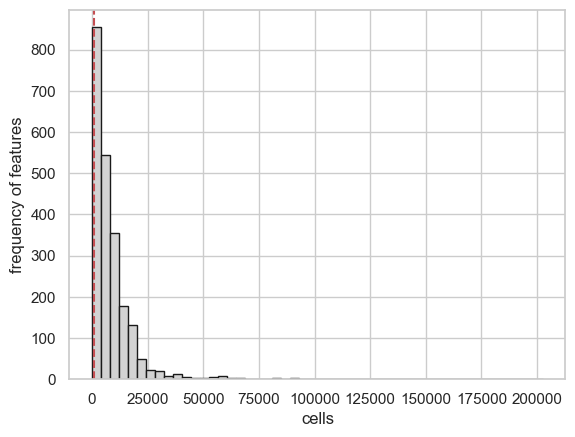

In [13]:
scATAcat.plot_cell_statistics(sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

### 4- filter the cells and features

`preproces_sc_matrix()` function is used to filter unwanted cells and features. By default, eatures which occur in less than `feature_cutoff=3` cells get eliminated. In the level of cells, we filter out cells with fewer than `feature_cutoff=1000` and more than `cell_cutoff_max=80000` non-zero features. Additionally, we get rid of the features within Y chromosome to avoid gender biases, controlled by `remove_chrY = True` paramater.

In [14]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 2210 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

In [15]:
sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(sc_completeFeatures_adata,cell_cutoff=1000,cell_cutoff_max=80000, feature_cutoff=3, remove_chrY = True, var_key = 'cCREs', copy=True)

In [16]:
sc_filteredFeatures_adata

View of AnnData object with n_obs × n_vars = 1872 × 501699
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

#### note that here we filtered almost half of the features!

### 5- load & preprocess the bulk data

scATAcat requires bulk prototype data to provide cell-type annotation for query scATAC-seq data. For this tutorial, we use prototype cell-types derived from bulk ATAC-seq data of hematopoietic progenitors from [Corces et al., 2016](https://www.nature.com/articles/ng.3646). This dataset comprises of bulk ATAC-seq data of hematopoietic progenitors, serving as an perfect example for our purposes.
An AnnData object containing this dataset can easily be generated using the `generate_bulk_sparse_AnnData()` function, which prepares the data in a format suitable for scATAcat analysis. 
`data/bulk_prototypes.pkl` matrix includes the cCRE coverages of each bulk sample.

In [17]:
bulk_by_ENCODE_peaks_df_annotated = pickle.load(open(data_dir + 'bulk_prototypes.pkl','rb'))

In [18]:
bulk_completeFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(bulk_by_ENCODE_peaks_df_annotated)

In [19]:
bulk_completeFeatures_adata

AnnData object with n_obs × n_vars = 43 × 926535
    obs: 'cell_types'
    var: 'cCREs'

`preprocess_bulk_adata()` function preprocesses prototype/bulk AnnData by optionally removing features associated with chromosome Y, controlled by `remove_chrY = True` paramater.

In [20]:
bulk_completeFeatures_adata = scATAcat.preprocess_bulk_adata(bulk_completeFeatures_adata, remove_chrY=True, var_key = 'cCREs', copy=False)

### 6 - Overlap bulk and sc features

Before we proceed with our analysis, it's essential to align the features between the bulk and single-cell (sc) AnnData objects. Although we initially used the same set of candidate cis-regulatory elements (cCREs), different filtering criteria applied to the bulk and sc data may have resulted in discrepancies. A unified feature set is crucial for integrating these datasets effectively.
We define the common variables with `overlap_vars()` function and subset both the AnnData objects to these common variables using `subset_adata_vars()` function.

In [21]:
sc_bulk_common_vars = scATAcat.overlap_vars(sc_filteredFeatures_adata, bulk_completeFeatures_adata)

In [22]:
len(sc_bulk_common_vars)

501699

In [23]:
sc_commonFeatures_adata = scATAcat.subset_adata_vars(sc_filteredFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


In [24]:
bulk_commonFeatures_adata = scATAcat.subset_adata_vars(bulk_completeFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


### 7- doublet removal

If you've applied a doublet detection algorithm, this is a good place to remove these cells from your analysis. In our case, removal isn't necessary as our data was obtained from sorted individual cells. However, we strongly recommend removing doublets from the analysis, as these cells can significantly impact downstream analysis. We have used [AMULET](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02469-x) and have achieved good results with it.

### 8- apply TF-IDF

We continue with processign our sc data. We apply TF-logIDF normalization. This results in re-weighted features (cCREs) by assigning greater weight to more important features. 

In [25]:
scATAcat.apply_TFIDF_sparse(sc_commonFeatures_adata, binary_layer_key='binary', TFIDF_key='TF_logIDF' )

AnnData object with n_obs × n_vars = 1872 × 501699
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

### 9 - subset matrices to differential cCREs

Next, we subset the data to focus on the differential cCREs as defined by the reference bulk ATAC-seq data. These regions are identified using the DiffBind R package (version 3.0) by conducting pairwise comparisons between each cell type. The file `data/differential_features.csv` contains the union of the top 2000 differential cCREs from each comparison

We next subset both the sc and bulk AnnData objects to these differential regions with the assumption that these specific cCREs contain the most discriminative information and are indicative of cell-type specificity.

In [26]:
pairwise_top2000_cCREs = pd.read_table(data_dir +'/differential_features.csv',delimiter="\t",header=None)

pairwise_top2000_cCREs.head()

,0
0,chr1_1842820_1843169
1,chr1_1895700_1895891
2,chr1_1895944_1896292
3,chr1_1966481_1966686
4,chr1_2045674_2045954


In [27]:
len(pairwise_top2000_cCREs)

21034

In [28]:
common_differential_vars = list(set(list(sc_bulk_common_vars)) & set(list(pairwise_top2000_cCREs[0].tolist())))

len(common_differential_vars)

19412

In [29]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [30]:
sc_commonDiffFeatures_adata = scATAcat.subset_adata_vars(sc_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

### 10- dimention reduction and clustering 

The next step is dimension reduction. We apply principal component analysis (PCA) using `apply_PCA()` function. 
Sometimes the first principal component may capture the variation in the sequencing depth among among cells rather than biological variation. In such instances, it might be advisable to exclude the first PC. Below, we examine whether there is such an association.

In [31]:
scATAcat.apply_PCA(sc_commonDiffFeatures_adata, layer_key ='TF_logIDF', svd_solver='arpack', random_state=0)


AnnData object with n_obs × n_vars = 1872 × 19412
    obs: 'cell_IDs'
    var: 'cCREs'
    uns: 'pca'
    obsm: 'num_feature_per_cell', 'X_pca'
    varm: 'num_cell_per_feature', 'PCs'
    layers: 'binary', 'TF_logIDF'

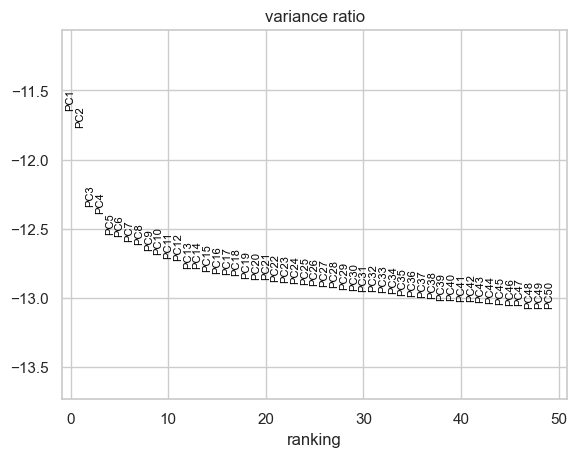

In [32]:
with plt.rc_context():
    sc.pl.pca_variance_ratio(sc_commonDiffFeatures_adata, n_pcs=50, log=True, show=False)
    plt.savefig(figures_dir + "/pca_variance_ratio.pdf", bbox_inches="tight")

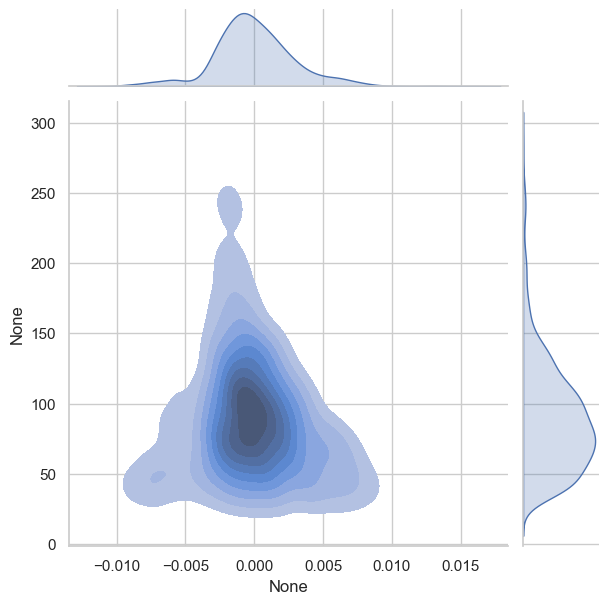

In [33]:
seqDepth_PC1_plot = sns.jointplot(
    x=sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    y=np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']),
    kind="kde",fill=True
)

### 11 -  apply UMAP & leiden clustering

Next, we compute the nearest neighbors and apply Leiden clustering. These clusters are then visualized in a low-dimensional UMAP embedding. Note that we these funtions are borrowed from [ScanPy](https://scanpy.readthedocs.io/en/latest/index.html) package.

In [34]:
sc.pp.neighbors(sc_commonDiffFeatures_adata, n_pcs = 50, n_neighbors = 30, random_state=0)


In [35]:
leiden_resolution=0.4
leiden_key="leiden_"+ str(leiden_resolution)

In [36]:
sc.tl.umap(sc_commonDiffFeatures_adata, random_state=0)

In [37]:
sc.tl.leiden(sc_commonDiffFeatures_adata, resolution=leiden_resolution,key_added=leiden_key, random_state=0)

In [38]:
# one can explicity specify the colors of their liking
sc_commonDiffFeatures_adata.uns[leiden_key +'_colors'] = ['#1f77b4',
'#ff7f0e',
'#d62728',
'#8c564b',
'#e377c2',
'#bcbd22',
'#17becf',
'#2ca02c']

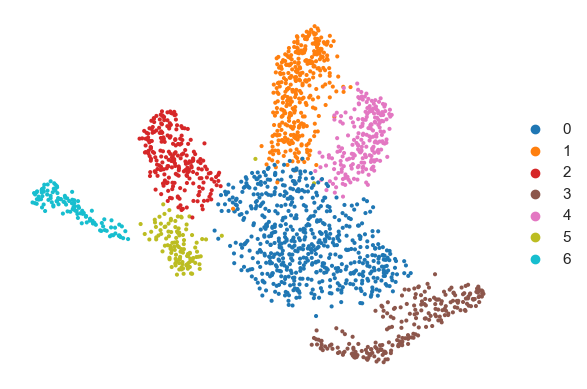

In [39]:
with plt.rc_context():
    sc.pl.umap(sc_commonDiffFeatures_adata, color=leiden_key, show=False,size=35 , add_outline=False, frameon=False, title="")
    plt.savefig(figures_dir + "/"+ leiden_key+ ".pdf", bbox_inches="tight")

We can also examine the sequencing depth of cells to determine if it impacts the clustering results:

In [40]:
sc_commonDiffFeatures_adata.obs['num_feature_per_cell_'] = sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']

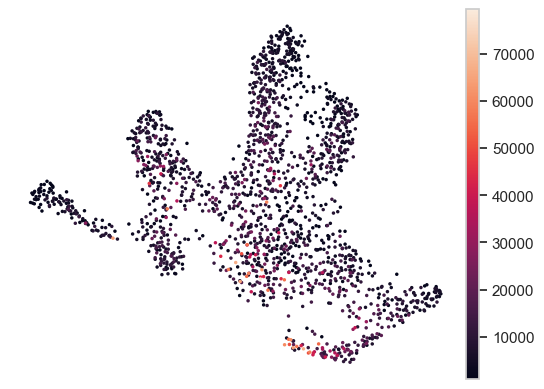

<Figure size 640x480 with 0 Axes>

In [41]:

with plt.rc_context():  
    sc.pl.umap(sc_commonDiffFeatures_adata, color='num_feature_per_cell_', add_outline=False, frameon=False,title ="", save=False, size=25 )
    plt.savefig(figures_dir + "/seq_depth_umap.pdf", bbox_inches="tight")

### 12 - create pseudobulks according to the cluster assignments

We form pseudobulks by aggregating the cells in each cluster. `get_pseudobulk_matrix_ext()` function is used to obtain pseudobulk matrix and `generate_bulk_sparse_AnnData()` is repurposed to generate an AnnData object for the pseudobulks. Note that the pseudobulk matrix has the common cCREs as variables. 


In [42]:
cell_cluster_assignments = pd.DataFrame(sc_commonDiffFeatures_adata.obs[leiden_key].copy())
cell_cluster_assignments


,leiden_0.4
CLP_1,6
CMP_0,0
CMP_1,0
CMP_2,0
CMP_3,3
...,...
LMPP_90,5
LMPP_91,5
LMPP_93,5
LMPP_94,5


In [43]:
cell_cluster_sizes = pd.DataFrame(cell_cluster_assignments[leiden_key].value_counts())
cell_cluster_sizes['leiden_clusters'] = cell_cluster_sizes.index
cell_cluster_sizes.head()

,count,leiden_clusters
leiden_0.4,,
0,614,0
1,359,1
2,233,2
3,227,3
4,210,4


In [44]:
for clust_id in set(sc_commonDiffFeatures_adata.obs[leiden_key].values):
    clust_df= sc_commonDiffFeatures_adata[sc_commonDiffFeatures_adata.obs[leiden_key]==clust_id]

In [45]:
cell_types = ([(r.split('_')[0]) for r in clust_df.obs[leiden_key].index])

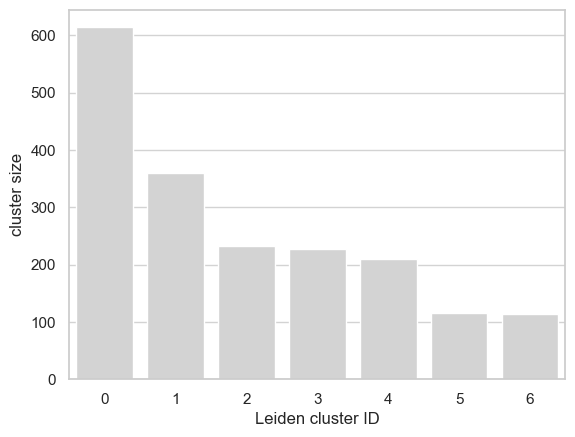

In [46]:
# plot a bar chart
sns.set_style("whitegrid")
ax= sns.barplot(
    y="count", 
    x="leiden_clusters", 
    data=cell_cluster_sizes, 
    color='lightgrey');
ax.yaxis.grid(True,color="lightgrey")
ax.axes.set_xlabel("Leiden cluster ID")
ax.axes.set_ylabel("cluster size")
#atickt(yticks=(list(range(0,1500,100))))
plt.savefig(figures_dir + "/cluster_sizes_"+leiden_key+".pdf", dpi=250)

### 13 - Coembedding prototypes with pseudobulks in PCA space



We preprocess both the bulk and pseudobulk data prior to co-embedding.

First, we apply library size normalization and log2 transformation to the datasets using the `preprocessing_libsize_norm_log2()` function, then subset the matrices to include only differential cCREs.

Next, we perform z-normalization using the `preprocessing_standardization()` function. This function can also accept external parameters for standard deviation (`std_`) and mean (`mean_`). When normalizing the pseudobulk matrix, we utilize the std_ and mean_ values from the bulk AnnData to facilitate the integration of these datasets.

#### processing 

In [47]:
pseudobulk_commonFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(scATAcat.get_pseudobulk_matrix_ext(adata_to_subset=sc_commonFeatures_adata, adata_to_get_clusters=sc_commonDiffFeatures_adata, cluster_key=leiden_key, method = 'sum'))

In [48]:
pseudobulk_commonFeatures_adata

AnnData object with n_obs × n_vars = 7 × 501699
    obs: 'cell_types'
    var: 'cCREs'

In [49]:
scATAcat.preprocessing_libsize_norm_log2(pseudobulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 7 × 501699
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [50]:
scATAcat.preprocessing_libsize_norm_log2(bulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 43 × 501699
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [51]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [52]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [53]:
pseudobulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(pseudobulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [54]:
scATAcat.preprocessing_standardization(bulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=True)

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [55]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 43 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [56]:
scATAcat.preprocessing_standardization(pseudobulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=False,
                              output_layer_key= "libsize_norm_log2_bulk_scaled_diff",
                              std_key= None,  mean_key=None,
                              std_ = bulk_commonDiffFeatures_adata.var["feature_std"],
                              mean_= bulk_commonDiffFeatures_adata.var["feature_mean"])

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 7 × 19412
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_bulk_scaled_diff'

In [57]:
## as an option, I can add the color codes from the clustering/ sc adata as a paramater for the pseudobulk matrix 
leiden_color_key = leiden_key+"_colors"
pseudobulk_commonDiffFeatures_adata.uns[leiden_color_key] = sc_commonDiffFeatures_adata.uns[leiden_color_key]

#### Projection
Finally, we co-embed the bulk prototypes together with the pseudobulks using the projection() function.
This function provides highly customizable visualization options, some of which are provided below

In [58]:
## as an option, one can add the color codes from the clustering of sc adata as a paramater for the pseudobulk matrix 
leiden_color_key = leiden_key+"_colors"
pseudobulk_commonDiffFeatures_adata.uns[leiden_color_key] = sc_commonDiffFeatures_adata.uns[leiden_color_key]

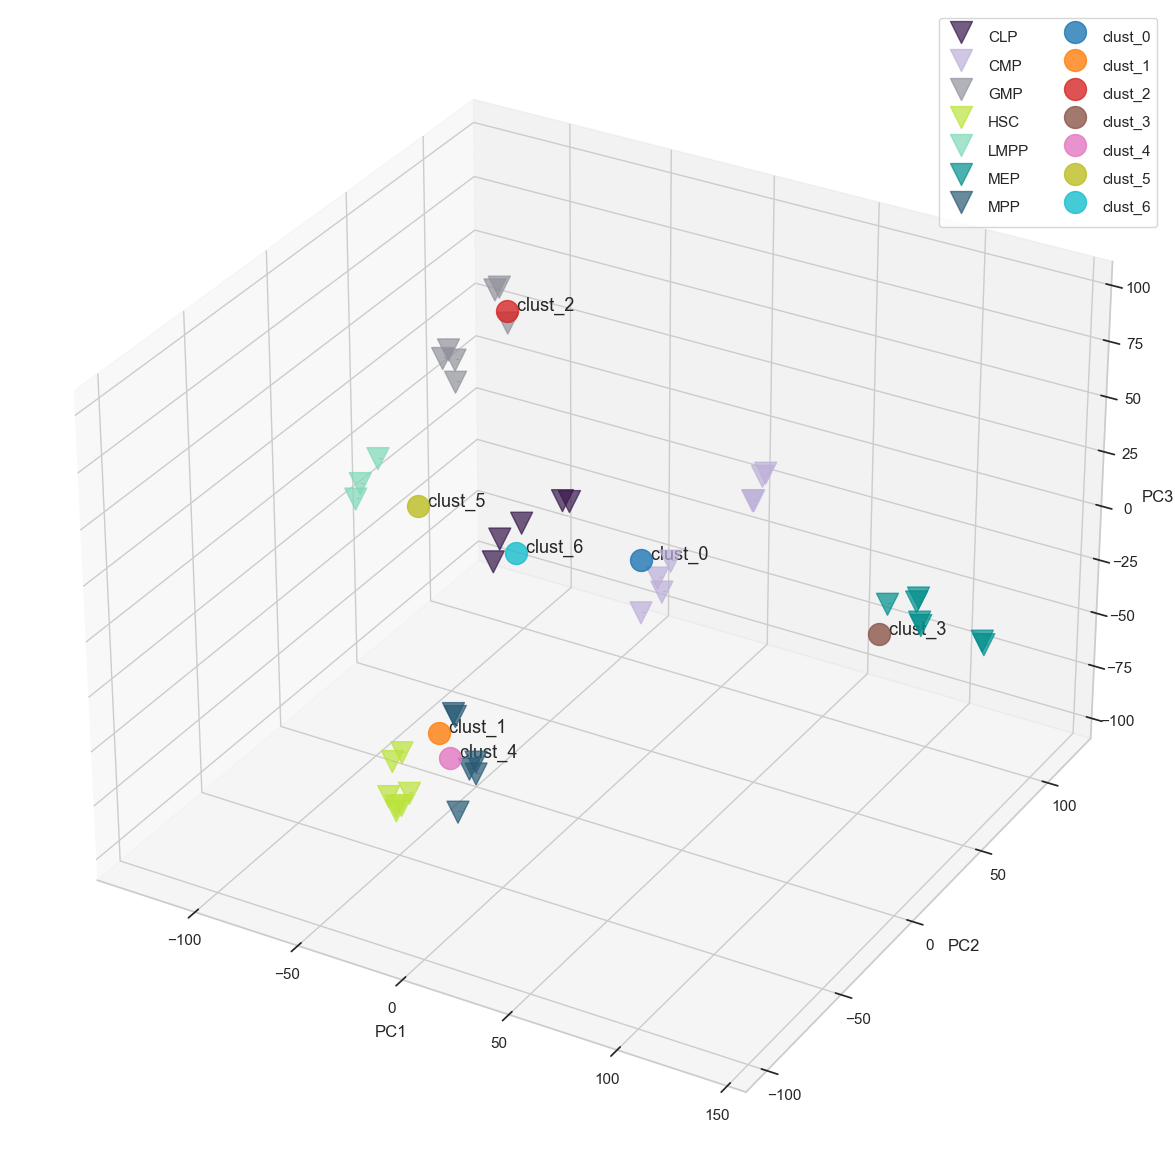

In [59]:
result= scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =13, prototype_label_font_size = 0,
prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection.png")

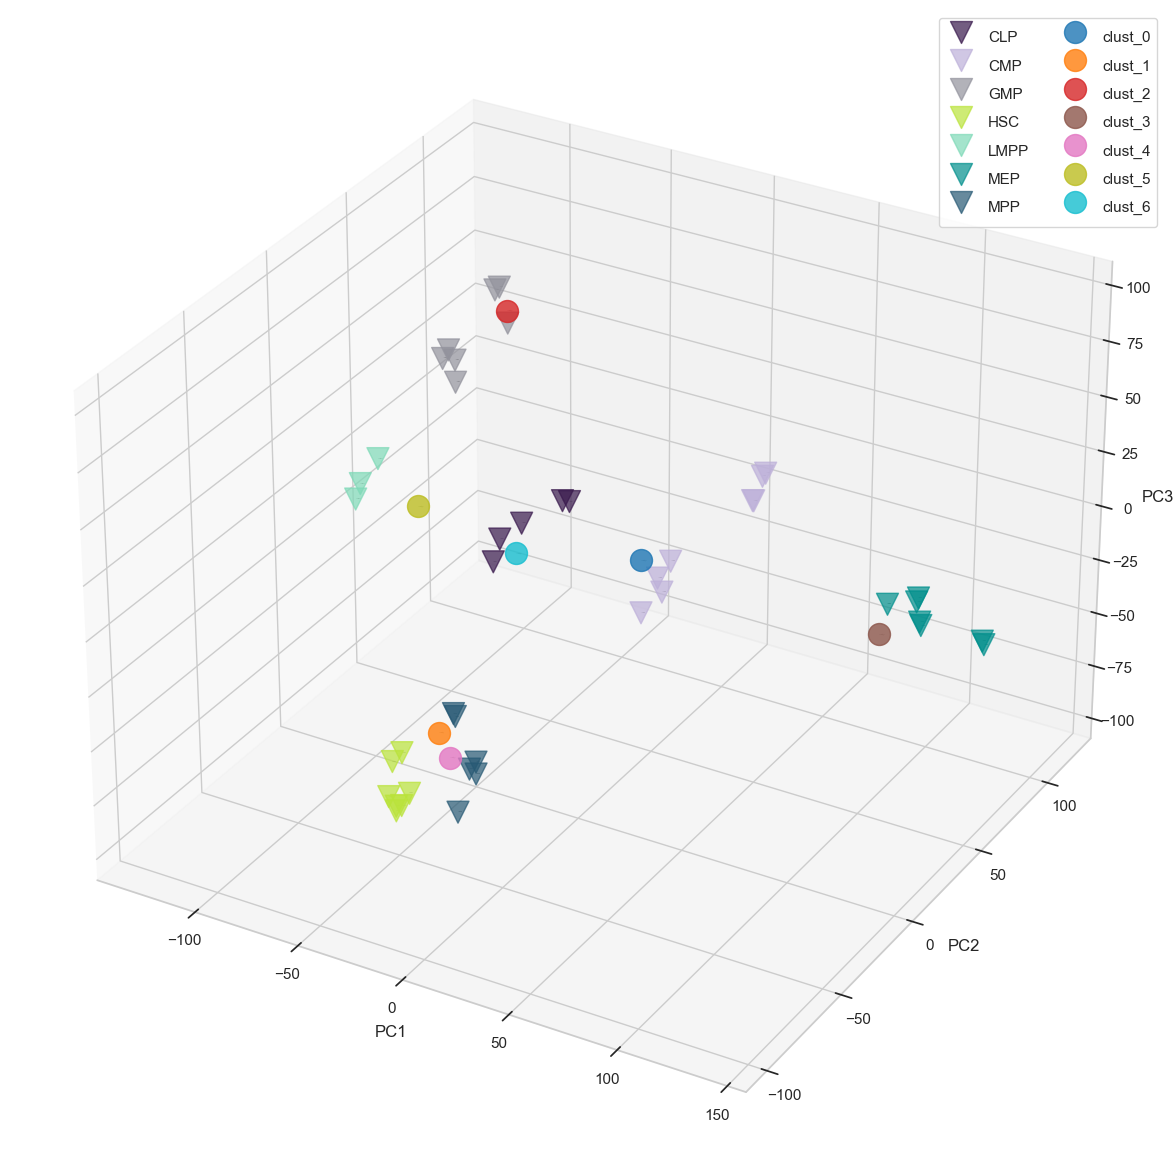

In [60]:
result_noLabel = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection_noLabel.png")

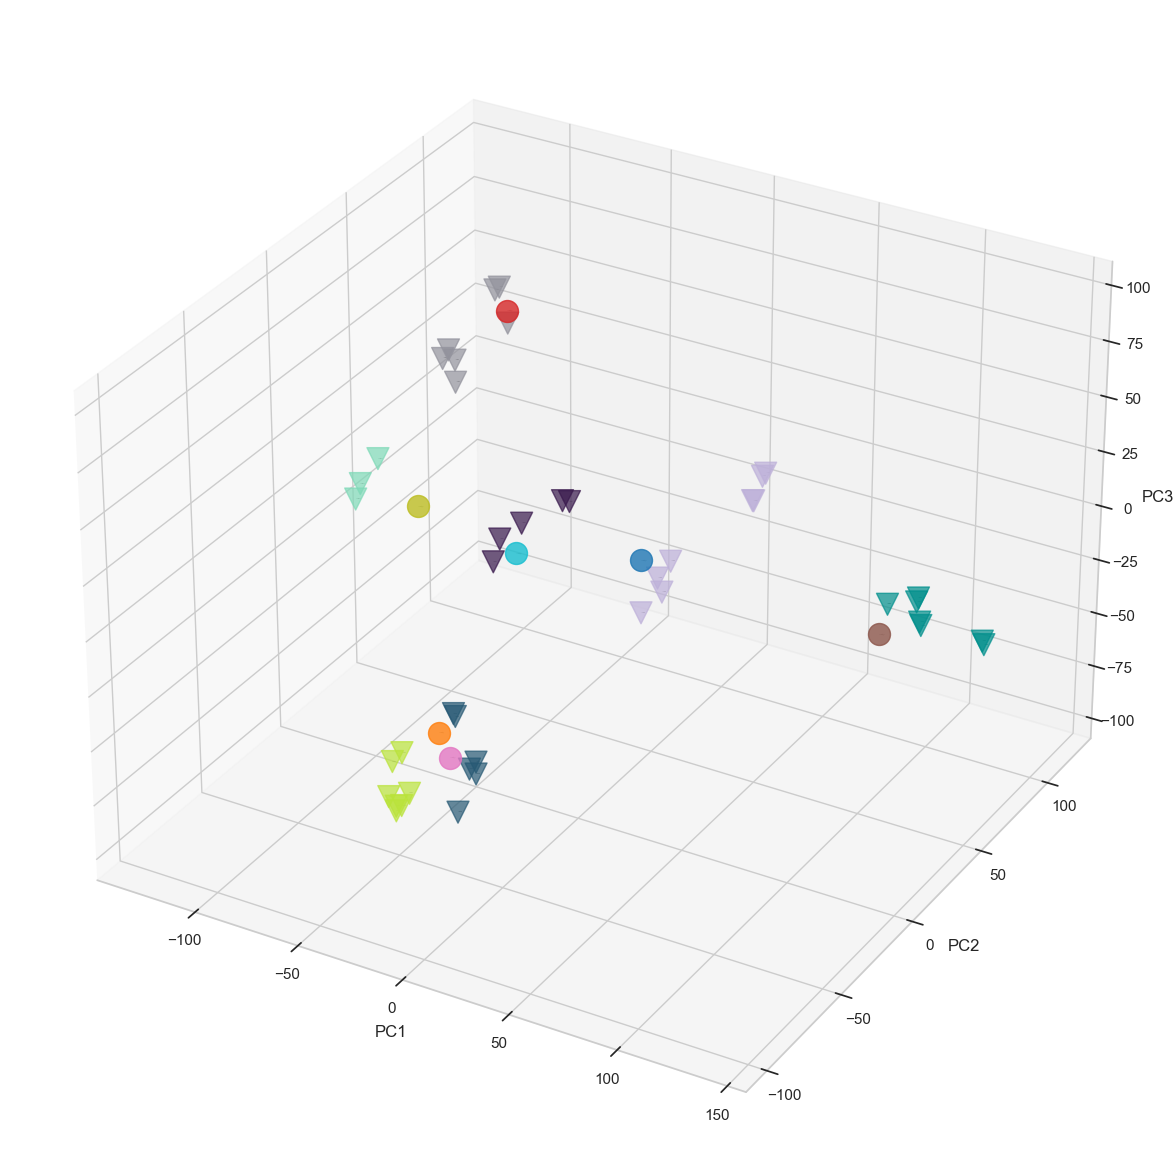

In [61]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.png", fig_size_inches=(15,15))


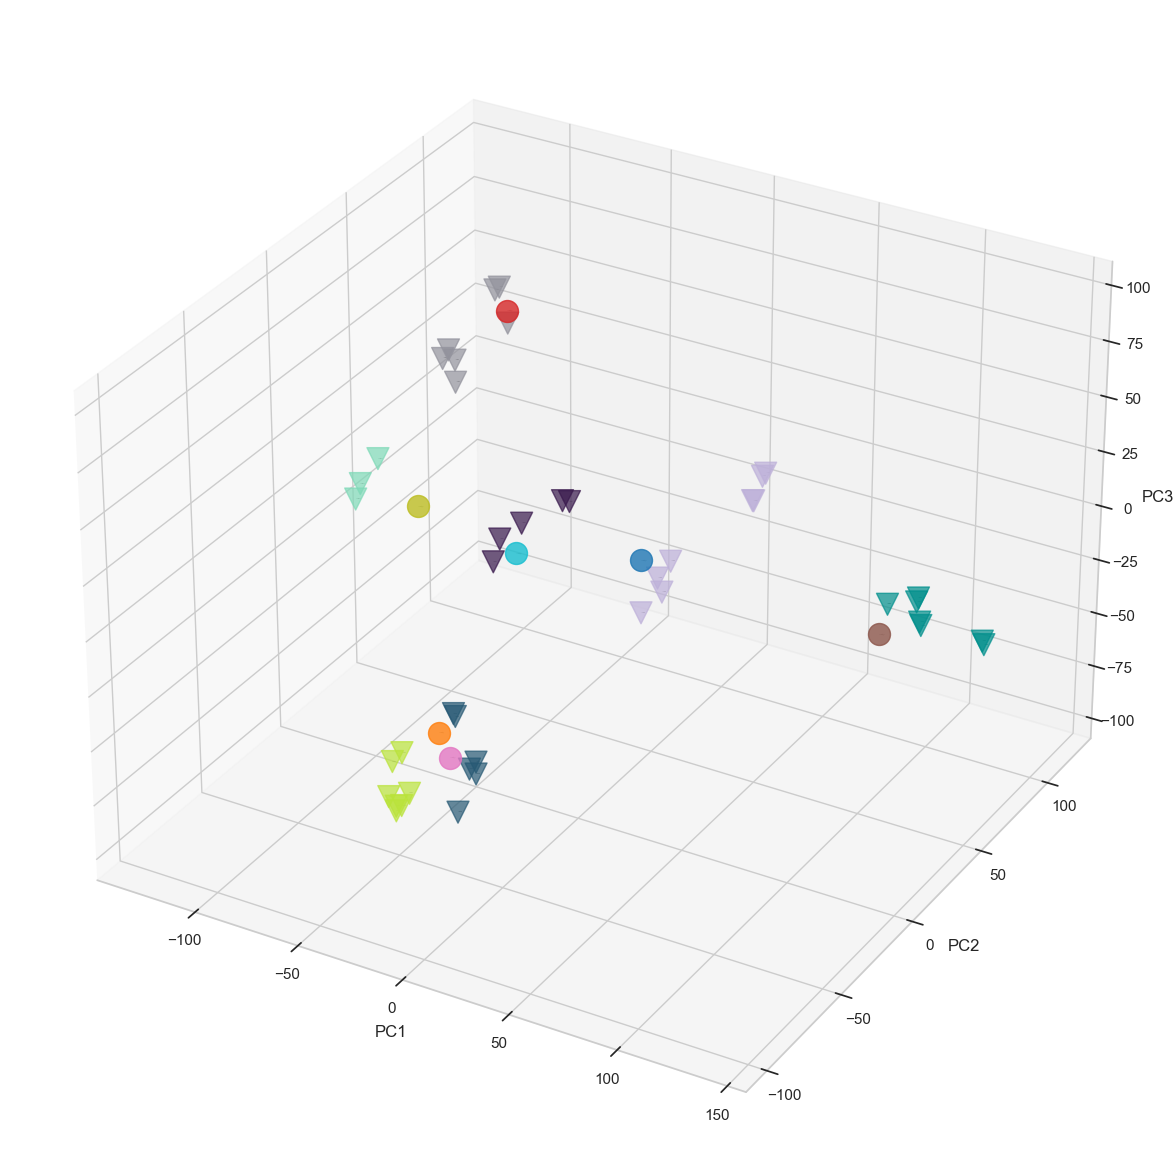

In [62]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C',  "#BDB0D9", "#92929C","#BAE33A", "#7ED9B7", "#008F8C", "#275974"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.pdf", fig_size_inches=(15,15))


### 14 - Determining the cluster annotations by matching Clusters to Prototypes

Co-embedding protoypes with pseudobulks, and visualizing the projection in 3D PCA space facilitates a simplified interpretation of cell-type relationships. However, determining the annotations solely based on a visualisation may be tedious. In particular, the first three PCs used in the projection might not suffice to fully capture the inherent structure of the high dimensional data. Following common practice, we therefore keep a larger number of dimension (typically 30 if there are enough samples available) to compute Euclidean distances in this high-dimensional embedding space.

To obtain a matching between pseudobulk clusters and prototype samples, we first compute centroids for each of the prototype cell-types. Next, we compute the Euclidean distances (in many dimensions) between the pseudobulk clusters and the centroids, yielding a matrix vizualized in heatmap.
Finally, we annotate each pseudobulk cluster by its closest centroid of a cell-type.

Below, we provide various data visualization options that are useful for interpreting the relationships between pseudobulks and prototypes


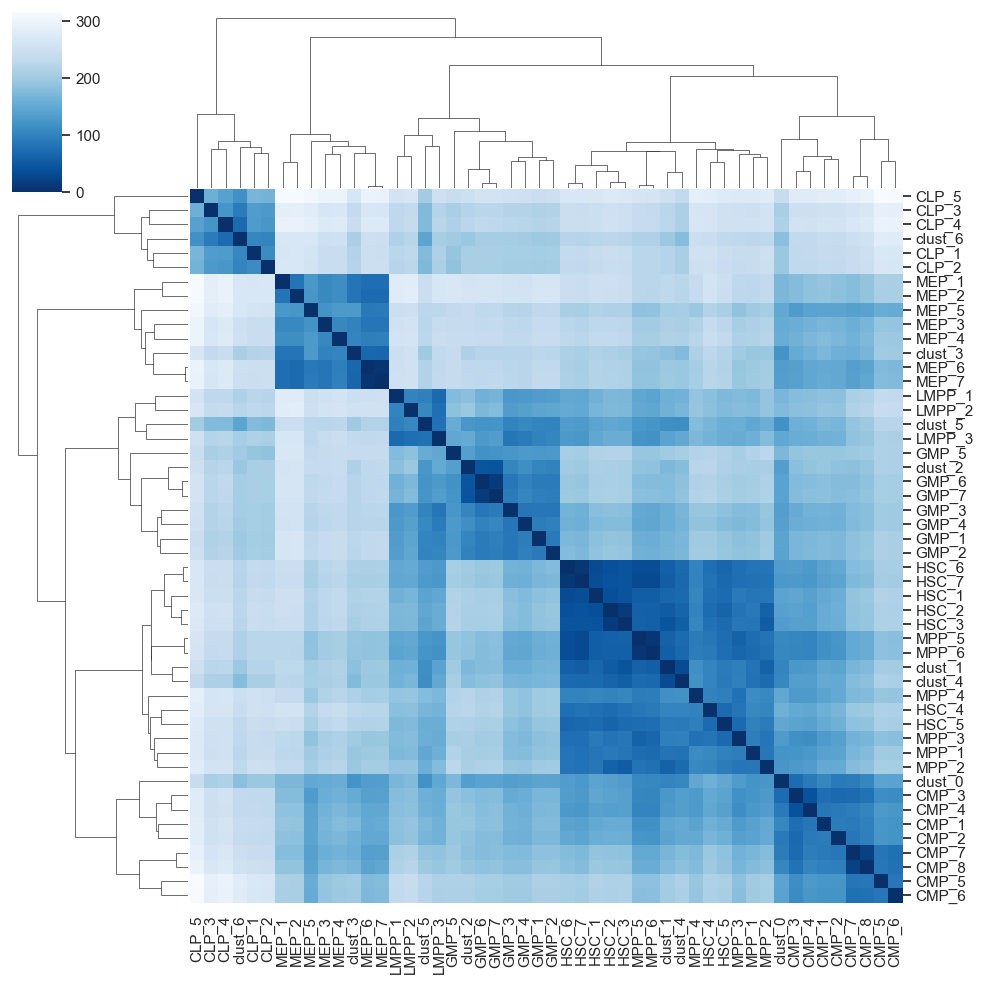

In [63]:
heatmap = scATAcat.plot_pca_dist_heatmap(result[1],result[2])

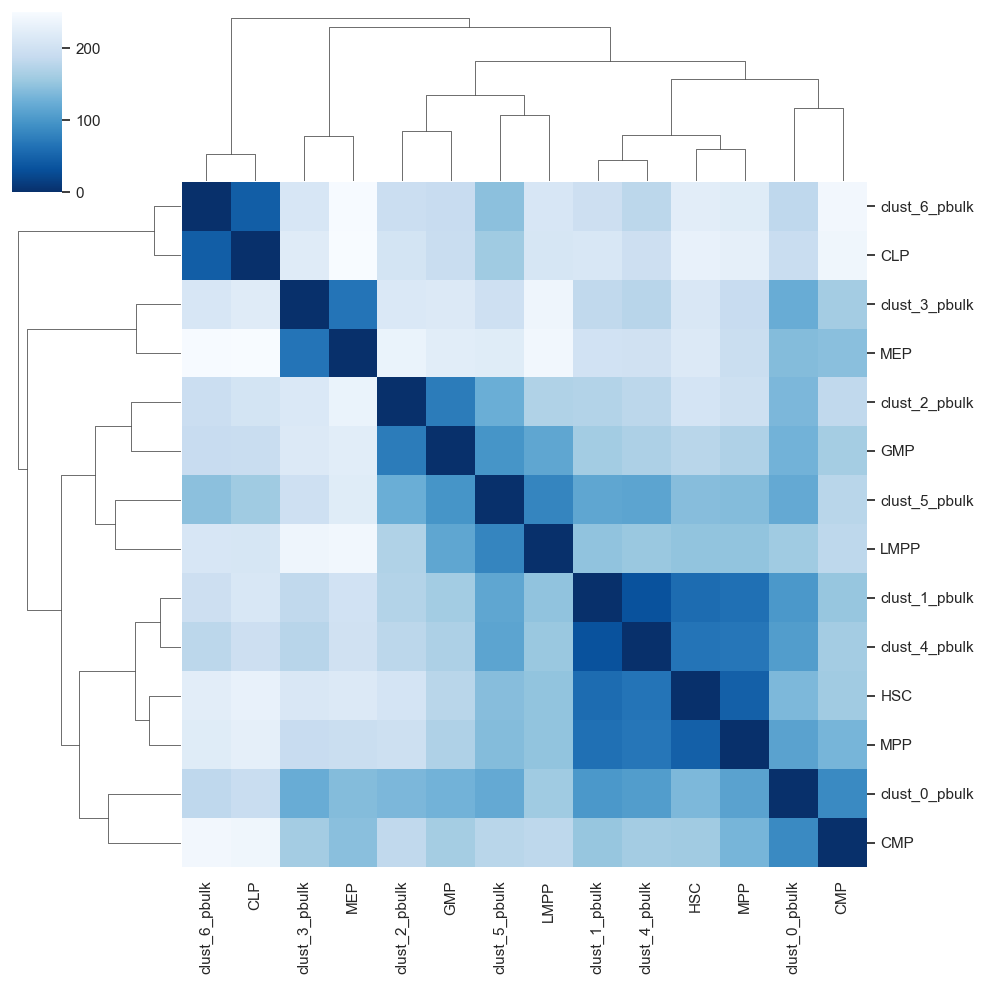

In [64]:
centroid_heatmap =  scATAcat.plot_pca_dist_cent_heatmap(result[1],result[2])


In [65]:
heatmap[0].savefig(figures_dir +"/heatmap.png") 
centroid_heatmap[0].savefig(figures_dir +"/centroid_heatmap.png") 


In [66]:
clusterID_prediction_dict = scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])
clusterID_prediction_dict

{'clust_0_pbulk': 'CMP',
 'clust_1_pbulk': 'HSC',
 'clust_2_pbulk': 'GMP',
 'clust_3_pbulk': 'MEP',
 'clust_4_pbulk': 'HSC',
 'clust_5_pbulk': 'LMPP',
 'clust_6_pbulk': 'CLP'}

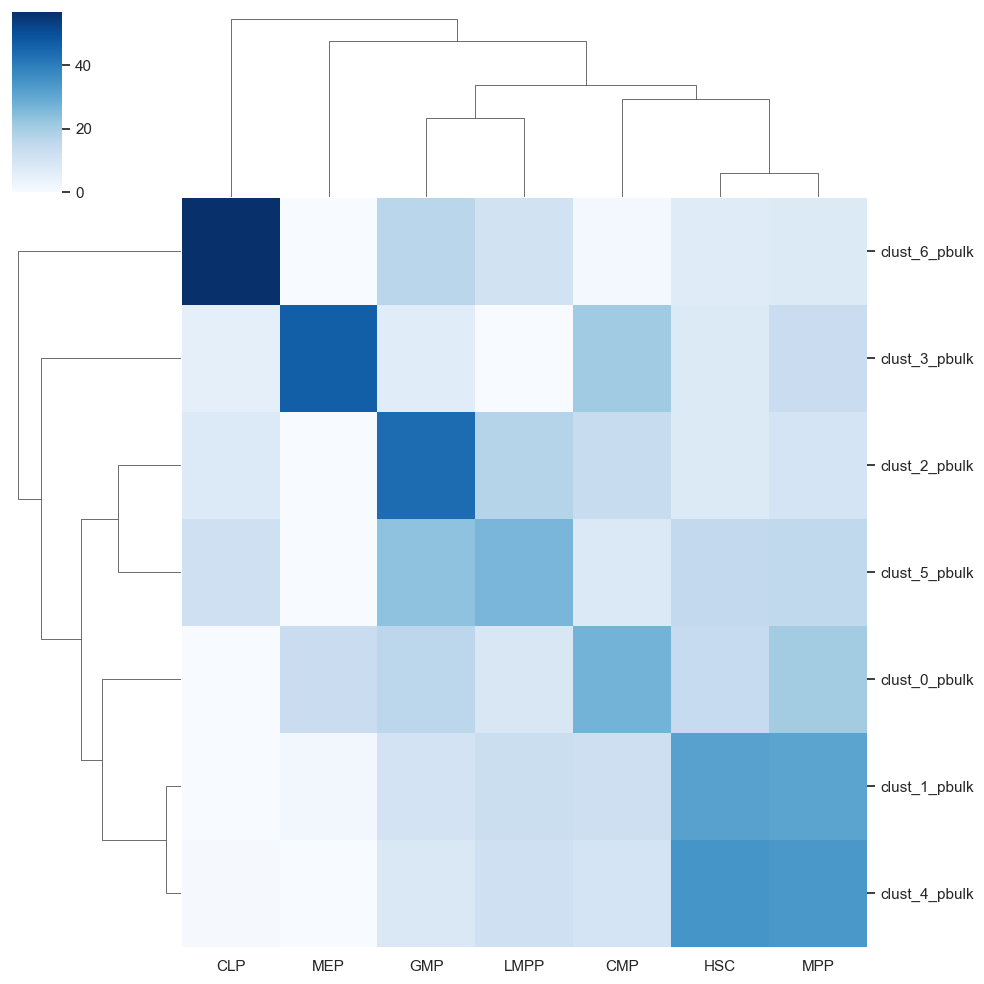

In [67]:
cluster_to_pseudobulk_heatmap_plot = sns.clustermap(scATAcat.get_pseudobulk_to_prototype_distance(centroid_heatmap[1], pbulk_to_prototype=True).T,yticklabels=True,xticklabels=True, cmap="Blues")

In [68]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.png") 


In [69]:
# save vestor friendly pdf file
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.pdf") 


### 15 - make a final dataframe including the cluster IDs and the final annotations of each cell:


In [70]:
cell_cluster_assignments

,leiden_0.4
CLP_1,6
CMP_0,0
CMP_1,0
CMP_2,0
CMP_3,3
...,...
LMPP_90,5
LMPP_91,5
LMPP_93,5
LMPP_94,5


In [71]:
modified_dict = {key.replace('clust_', '').replace('_pbulk', ''): value for key, value in clusterID_prediction_dict.items()}

print(modified_dict)

{'0': 'CMP', '1': 'HSC', '2': 'GMP', '3': 'MEP', '4': 'HSC', '5': 'LMPP', '6': 'CLP'}


In [72]:
# Convert cluster IDs to string if they are not already, to match the dictionary keys
cell_cluster_assignments['leiden_0.4'] = cell_cluster_assignments['leiden_0.4'].astype(str)

# Add a new column by mapping the 'ID' column to the modified_dict
cell_cluster_assignments['Annotation'] = cell_cluster_assignments['leiden_0.4'].map(modified_dict)

cell_cluster_assignments

,leiden_0.4,Annotation
CLP_1,6,CLP
CMP_0,0,CMP
CMP_1,0,CMP
CMP_2,0,CMP
CMP_3,3,MEP
...,...,...
LMPP_90,5,LMPP
LMPP_91,5,LMPP
LMPP_93,5,LMPP
LMPP_94,5,LMPP


In [73]:
cell_cluster_assignments.to_csv(output_dir +"cell_cluster_assignments.csv")

### export AnnData object 